In [1]:
import os
import gc
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from tqdm import tqdm
from zipfile import ZipFile

In [2]:
out_dir = 'figs' # TODO path to file

In [3]:
one, two = None, None

In [ ]:
#######  CAREFUL: this code is mainly a copy of preprocess.py, this here is only for getting a nice figure  #######

In [45]:
def get_files_and_labels(input_path_spon, input_path_prey):
    files = []
    for filename in os.listdir(input_path_spon):
        files.append(input_path_spon + '/' + filename)
    labels = np.zeros(len(files), dtype=np.uint8)
    for filename in os.listdir(input_path_prey):
        files.append(input_path_prey + '/' + filename)
    labels = np.concatenate((labels, np.ones(len(files) - len(labels), dtype=np.uint8)))
    if debug:
        print("len files", len(files), "len labels", len(labels))
    return files, labels


# Reads all avi-files and extracts events and labels
def get_events_and_labels(files, labels, zfile=None):
    all_vids = None  # holds all samples extracted from the videos given in caps
    targets = None

    if debug:
        print("Debug mode. Using only", max_files, "files.")
        files = files[:max_files]
    i = 0  # counter to index labels[i]

    if debug: print("len files", len(files))

    for file in tqdm(files):
        if file.lower().endswith('.avi'):
            vids = extract_vids(file, zfile)
            if debug:
                print("vids.shape", vids.shape)

            if all_vids is None:
                all_vids = vids
                targets = np.ones(len(vids), dtype=np.uint8) * labels[i]
            else:
                all_vids = np.concatenate((all_vids, vids))
                targets = np.concatenate((targets, np.ones(len(vids), dtype=np.uint8) * labels[i]))

        i += 1

    return all_vids, targets


def find_frame_dimensions(frame, show_frames=True):  # optimal dimensions depend on the position of the tail in the frame
    height, width = frame.shape

    #     plt.hist(frame.flatten())
    #     plt.show()

    #     print("Raw frame")
    # fig = plt.figure(figsize=(5, 5))
    # plt.imshow(frame, cmap='gray')
    # plt.show()

    frame = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    kernel_size = 3
    frame = cv2.GaussianBlur(frame, (kernel_size, kernel_size), 0)  # apply slight low-pass filter


    # Set gamma value depending on the skewness of the overall histogram of pixel values,
    # where skewness in (-inf, inf) and gamma in [0, inf).
    # Furthermore, negative skewness should set gamma in [0,1) and positive in (1, inf).
    # Thus, we apply an exponential function.
    skewness = skew(frame.flatten())
    if debug: print("Skewness", skewness)
    gamma = np.exp(-skewness / gamma_transformation_parameter)
    if debug: print("Gamma", gamma)

    # Gamma correction
    frame = np.array(np.clip(pow(frame / 255.0, gamma) * 255.0, 0, 255), dtype=np.uint8)

    # contour_threshold can be the same value for all videos, but we have to standardize the videos first, i.e.
    # increase contrast (use gamma)
    _, thresh = cv2.threshold(frame, contour_threshold, 255, cv2.THRESH_BINARY)
    _, thresh_inv = cv2.threshold(frame, contour_threshold, 255, cv2.THRESH_BINARY_INV)

#     if debug and show_frames:
#         show_frames = False
#         print("Showing first frame of video after bladder detection")
#         fig = plt.figure(figsize=(12, 15))
#         plt.subplot(121)
#         plt.imshow(frame, cmap='gray')
#         plt.imshow(thresh_inv, 'Greys', interpolation='none', alpha=0.7)
#         plt.subplot(121)
#         plt.tight_layout()
#         plt.savefig("frame.pdf")
#         plt.show()

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #     cv2.drawContours(frame, contours, -1, (0,255,0), 3)

    centers = []
    rights = []

    for c in contours[1:]:  # the first contour is around the entire image, so we dismiss it
        #         M = cv2.moments(c)
        #         if M['m00'] != 0:
        #             cx = int(M['m10'] / M['m00'])
        #             cy = int(M['m01'] / M['m00'])
        #             centers.append([cx, cy])

        area = cv2.contourArea(c)
        area_percent = area * 100 / (width * height)
        extRight = tuple(c[c[:, :, 0].argmax()][0])  # (x,y) of right-most pixel of contour

        #         print(area_percent, extRight)

        if area_percent > 0.01:  # omit tiny areas
            rights.append(extRight)

    #         print("cx: {}, cy: {}".format(cx,cy))

    #     centers = np.array(centers)
    rights = np.array(rights)

    #     print(rights.shape)

    right_most_idx = np.argmax(rights, axis=0)[0]
    #     print(rights, right_most_idx)
    right_most = rights[right_most_idx]  # [x y]
    #     print(right_most)

    #         print(np.average(centers, axis=0)[1])
    #     top = int(np.average(centers, axis=0)[1] - 128)
    top = int(right_most[1] - 128)
    if top < 0:
        top = 0
    bottom = int(top + 256)
    if bottom > height:
        move_up = bottom - height
        bottom -= move_up
        top -= move_up

    #     left = int(centers.max(axis=0)[0])  # take the right-most contour; must be the bladder of the fish
    left = int(right_most[0] - 10)
    if left < 0:
        left = 0
    right = int(left + 256)
    if right > width:
        move_left = right - width
        right -= move_left
        left -= move_left

    #     print(top, bottom, left, right)
    return top, bottom, left, right, frame, thresh_inv


def detect_movement(frame, prev_frame):
    global movement_threshold

    height, width = frame.shape

    frame = cv2.GaussianBlur(frame, (5, 5), 0)  # apply low-pass filter
    prev_frame = cv2.GaussianBlur(prev_frame, (5, 5), 0)
    _, binary = cv2.threshold(frame, movement_threshold, 255, cv2.THRESH_BINARY)
    _, prev_binary = cv2.threshold(prev_frame, movement_threshold, 255, cv2.THRESH_BINARY)

    frame_delta = cv2.absdiff(prev_binary, binary)
    #     print(np.sum(frame_delta)/(height*width*255))
    if np.sum(frame_delta) / (height * width * 255) > change_threshold:  # percentage of pixel values that have changed
        return True

    #     plt.imshow(thresh,cmap='gray')
    #     plt.show()
    return False


def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)


# If there is a certain number of consecutive frames with detected motion, declare this frame a video start.
def get_video_starts(idxs_with_motion, thresh):
    consec = consecutive(idxs_with_motion)
    video_starts = []
    bound = -vid_length
    for c in consec:
        if len(c) >= thresh and c[0] >= bound:
            # dismiss movements that happen within 150 frames or have less than a certain nmber of frames
            #         print("c:",c)
            start = c[0] - start_buffer
            if start < 0:
                start = 0
            video_starts.append(start)
            bound = start + vid_length  # videos may not overlap even if there are distinct movements involved (because if two videos overlap and these two videos are in training and test datasets respectively, then that's clearly cheating)

    # print("consec movements:", consec)
    return video_starts


def extract_vids(file, zfile=None):
    # zfile is only used if files are read from a zipfile zfile
    # init variables:
    vid = []  # store content of file
    idxs_with_motion = []
    prev_frame = None
    top, bottom, left, right = -1, -1, -1, -1
    i = 0
    ret = True

    if zfile is not None:
        zfile.extract(file)

    cap = cv2.VideoCapture(file)

    while (ret):  # Read all frames
#         if i > 0: break
            
        ret, frame = cap.read()  # ret indicates whether the read was successful
        
        if ret and (i == 49 or i == 50):
            height, width, channels = frame.shape
            assert height >= 256, "Height too small"
            assert width >= 256, "Width too small"

            # turn to grayscale:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            #         gray = cv2.GaussianBlur(gray, (5, 5), 0) # we want to keep the details of the frame for the CNN

            # crop down:
            if top == -1 or bottom == -1 or left == -1 or right == -1:
                top, bottom, left, right, frame, thresh_inv = find_frame_dimensions(gray)
            crop_frame = gray[top:bottom, left:right]  # e.g. [54:310, 114:370]

            # normalize:
            norm_frame = cv2.normalize(src=crop_frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

            vid.append(norm_frame)

            # check if something moved compared to the previous frame:
            if prev_frame is not None and detect_movement(norm_frame, prev_frame):
                idxs_with_motion.append(i)
            prev_frame = norm_frame
            
            if i == 49:
                global one 
                one = norm_frame
            else:
                print(frame.shape)
                a = frame.shape[0] // 2
                b = frame.shape[1] // 2
                smaller_frame = frame[a-128:a+128, b-180:b+290]
                smaller_thresh = thresh_inv[a-128:a+128, b-180:b+290]
                
                flow = np.load('gray_frame.npy')

                f, (a0, a1, a2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1.85, 1, 1]}, figsize=(10,4))
                a0.imshow(smaller_frame, cmap='gray')
                a0.set_title("Detected Contours", fontsize=12)
                a0.imshow(smaller_thresh, 'Greys', interpolation='none', alpha=0.6)
                a1.tick_params(which='both',left=False,labelleft=False)
                a1.set_title("Cropped Frame", fontsize=12)
                a1.imshow(norm_frame, cmap='gray')
                a2.tick_params(which='both',left=False,labelleft=False)  
                a2.set_title("Flow Frame", fontsize=12)
                a2.imshow(255-flow, cmap='gray')
                plt.tight_layout()
                plt.savefig(os.path.join(out_dir, "frame.pdf"))
                plt.show()
            
                global two 
                two = norm_frame
                
                


                #         print(norm_frame.shape)
        i += 1

    cap.release()
    if zfile is not None:  # reading from zip-file
        os.remove(file)  # content of file is stored in vid

    ### All frames have been read ###

    vid = np.array(vid)
    total_video_length = i
#     assert total_video_length >= vid_length, "Video is too short."

    video_starts = []
    thresh = number_of_frames_for_motion_detection
    while not video_starts and thresh >= 2:  # video_starts empty, at least 2 motion-frames in a row
        video_starts = get_video_starts(idxs_with_motion, thresh)
        thresh = int(thresh / 2)
    if not video_starts:
        video_starts = [0]

    if debug:
        print("video_starts:", video_starts)

    # Add all extracted videos of length vid_length to vids:
    vids = []
    for start in video_starts:
        end = start + vid_length
        if end > total_video_length:
            shift = end - total_video_length
            start -= shift
            end -= shift
            # TODO this might make the last video overlap with the second-last!

        datapoint = vid[start:end]
        vids.append(datapoint)

    #         print("datapoint.shape:", datapoint.shape) # 150 frames, 256 height, 256 width

    return np.array(vids)



Reading avi files...
len files 1 len labels 1
Done reading 1 files.
Extracting events and labels...
Debug mode. Using only 20 files.
len files 1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Skewness -2.183969440027331
Gamma 1.6617975364249606
(400, 696, 3)


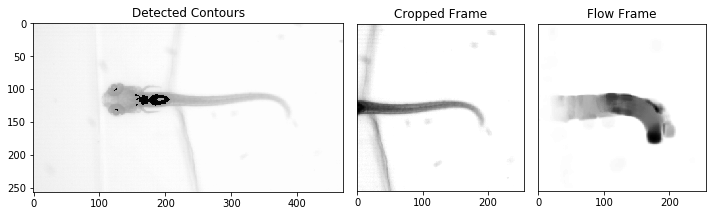

video_starts: [0]
vids.shape (1, 2, 256, 256)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Events shape: (1, 2, 256, 256), labels shape: (1,)
Saving data...
Finished.


In [46]:
# Debugging variables:
debug = True
show_frames = True
show_from = 0
show_every_nth_frame = 5
max_files = 20

do_augment = False
do_split = False

read_from_zip = False
label_of_zip = 0  # used only if read_from_zip==True

# These values must be tweaked carefully to make pre-processing work well:
gamma_transformation_parameter = 4.3
contour_threshold = 3  # threshold for contour detection (used for frame cropping)
movement_threshold = 200  # threshold for motion detection
change_threshold = 0.0038  # for detecting when the tail moves, meaning if 0.38% of thresholded image has changed, detect movement

# Global static constants:
start_buffer = 15  # number of frames to include before detected motion starts
vid_length = 150  # fixed target video length
number_of_frames_for_motion_detection = 6  # consecutive frames

input_path_spon = "data/spon"  # label 0
input_path_prey = "data/prey"  # label 1
# input_path_zip = "data/spontaneous_2.zip"
output_path = "data"

seed = 462019
np.random.seed(seed)

zfile = None
if read_from_zip:
    print("Files will be read sequentially from zip.")
    zfile = ZipFile(input_path_zip, mode='r', allowZip64=True)
    files = zfile.namelist()
    labels = np.ones(len(files), dtype=np.uint8) * label_of_zip
else:
    print("Reading avi files...")
    files, labels = get_files_and_labels(input_path_spon, input_path_prey)  # (capture based labels)
    print("Done reading {} files.".format(len(files)))

assert len(files) > 0, "No files found!"

# caps = [cv2.VideoCapture('prey/11-35-14.893.avi'), cv2.VideoCapture('prey/11-47-50.351.avi'),
#         #         cv2.VideoCapture('prey/14-25-40.583.avi'), cv2.VideoCapture('prey/18-33-41.983.avi'),
#         #         cv2.VideoCapture('spon/11-41-35.938.avi'), cv2.VideoCapture('spon/11-54-17.448.avi'),
#         cv2.VideoCapture('spon/11-59-47.148.avi'), cv2.VideoCapture('spon/22-05-09.126.avi')]
# labels = [1, 1, 0, 0]

print("Extracting events and labels...")
X, y = get_events_and_labels(files, labels,
                             zfile)  # X = all events, y = all corresponding labels (event based labels)

if read_from_zip:
    zfile.close()

print("Events shape: {}, labels shape: {}".format(X.shape, y.shape))

if do_augment:
    print("Augmenting data...")
    X, y = augment_data(X, y)

    print(
        f"Shapes after augmentation: "
        f"X={X.shape} "
        f"y={y.shape}, "
    )

if do_split:
    print("Splitting data...")
    # split data set into training, validation, test sets (70%, 15%, 15%)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )
    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, random_state=seed
    )

    print(
        f"Final shapes: "
        f"X_train={X_train.shape} "
        f"X_val={ X_val.shape}, "
        f"X_test={X_test.shape}, "
        f"y_train={y_train.shape}, "
        f"y_val={y_val.shape}, "
        f"y_test={y_test.shape}"
    )

    # savez_compressed saves lots of space (about 90% or more)
    if output_path:
        print("Saving split data...")
        np.savez_compressed(output_path + "-train.npz", inputs=X_train, targets=y_train)
        np.savez_compressed(output_path + "-valid.npz", inputs=X_val, targets=y_val)
        np.savez_compressed(output_path + "-test.npz", inputs=X_test, targets=y_test)
    else:
        print("No output path given, datasets were not saved.")
else:
    if output_path:
        print("Saving data...")
        np.savez_compressed(output_path + ".npz", inputs=X, targets=y)
    else:
        print("No output path given, dataset was not saved.")

print("Finished.")

# return [X_train, X_val, X_test, y_train, y_val, y_test]


In [6]:
# # generate some data
# x = np.arange(0, 10, 0.2)
# y = np.sin(x)

# # plot it
# f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
# a0.imshow(x, y)
# a1.plot(y, x)

# f.tight_layout()
# f.savefig('grid_figure.pdf')

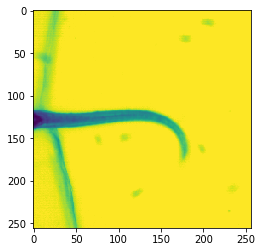

In [11]:
plt.imshow(one)

In [25]:
def show_flow(prvs, next):
#     flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, pyr_scale=0.8, levels=10, winsize=15, iterations=10, poly_n=13, poly_sigma=1.8, flags=0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1]) # get magnitude and direction/angle
    hsv = np.zeros((prvs.shape[0],prvs.shape[1],3), dtype=np.uint8)
    hsv[...,0] = ang*180/np.pi/2 # sets hue
    hsv[...,1] = 255 # # Sets image saturation to maximum
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX) # sets value/brightness
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    fig = plt.figure(figsize=(14,7))
    plt.subplot(121)
    plt.imshow(255-gray, cmap='gray')
    plt.subplot(122)
    plt.imshow(next,cmap='gray')
    plt.show()
    print(np.sum(hsv[...,2]))
    np.save('gray_frame.npy', gray)


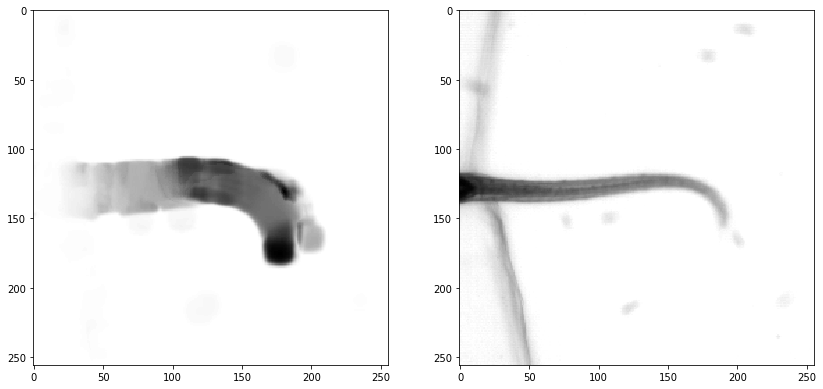

833490


In [26]:
# show_flow(one,two)